In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
import glob
import random
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import time

# Định nghĩa Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Sử dụng ResNet18 làm backbone, loại bỏ lớp fully connected
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()  # Loại bỏ lớp fully connected
        self.fc = nn.Linear(512, 128)  # Giảm chiều vector đặc trưng xuống 128

    def forward_one(self, x):
        # Xử lý một nhánh của Siamese Network
        x = self.backbone(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        # Xử lý hai hình ảnh đầu vào
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Hàm Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Tính khoảng cách Euclidean
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # Loss cho cặp giống nhau (label=1)
        loss_same = label * torch.pow(euclidean_distance, 2)
        # Loss cho cặp khác nhau (label=0)
        loss_diff = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        loss = torch.mean(loss_same + loss_diff) / 2
        return loss, euclidean_distance

# Định nghĩa dataset cho Siamese Network
class SiameseFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_to_idx = {}
        
        # Load tất cả ảnh và nhãn
        folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        for idx, folder in enumerate(sorted(folders)):
            self.label_to_idx[folder] = idx
            image_files = glob.glob(os.path.join(root_dir, folder, "*.jpg")) + \
                         glob.glob(os.path.join(root_dir, folder, "*.png"))
            for img_path in image_files:
                self.image_paths.append(img_path)
                self.labels.append(idx)
        
        self.num_classes = len(self.label_to_idx)
        self.label_to_images = {i: [] for i in range(self.num_classes)}
        for img_path, label in zip(self.image_paths, self.labels):
            self.label_to_images[label].append(img_path)

    def __len__(self):
        return len(self.image_paths) * 2  # Tăng số lượng mẫu để tạo cặp

    def __getitem__(self, idx):
        # Lấy ngẫu nhiên một ảnh
        img1_idx = random.randint(0, len(self.image_paths) - 1)
        img1_path = self.image_paths[img1_idx]
        label1 = self.labels[img1_idx]
        img1 = Image.open(img1_path).convert('RGB')

        # Quyết định ngẫu nhiên tạo cặp giống hay khác
        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            # Chọn một ảnh khác cùng lớp
            same_class_images = self.label_to_images[label1]
            img2_path = random.choice(same_class_images)
            label = 1  # Cùng người
        else:
            # Chọn một ảnh từ lớp khác
            different_class = random.choice([l for l in range(self.num_classes) if l != label1])
            img2_path = random.choice(self.label_to_images[different_class])
            label = 0  # Khác người

        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Hàm huấn luyện Siamese Network
def train_siamese_model(model, dataloader, criterion, optimizer, num_epochs=5, device='cuda'):
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss, distances = criterion(output1, output2, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Tính accuracy dựa trên ngưỡng khoảng cách
            predictions = (distances < 0.8).float()  # Ngưỡng 0.8 để phân loại
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # Lưu mô hình
    torch.save(model.state_dict(), 'siamese_face_recognition_model.pth')
    print("✅ Mô hình Siamese Network đã được lưu vào 'siamese_face_recognition_model.pth'")
    
    return train_losses, train_accuracies


# Hàm đánh giá Siamese Network
def evaluate_siamese_model(model, dataloader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2 = model(img1, img2)
            _, distances = ContrastiveLoss()(output1, output2, labels)
            predictions = (distances < 1.0).float()  # Ngưỡng 1.0
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Tính F1 score, precision, recall
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    # In báo cáo chi tiết
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Different', 'Same']))
    
    return f1, precision, recall

# Hàm dự đoán cho một ảnh
def predict_siamese(model, image, reference_images, transform, label_to_idx, device='cuda', threshold=1.0):
    model.eval()
    start_time = time.time()
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    min_distance = float('inf')
    predicted_label = "Unknown"
    
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        feature1 = model.forward_one(image_tensor)
        
        for ref_img_path, ref_label in reference_images:
            ref_img = Image.open(ref_img_path).convert('RGB')
            ref_tensor = transform(ref_img).unsqueeze(0).to(device)
            feature2 = model.forward_one(ref_tensor)
            distance = torch.nn.functional.pairwise_distance(feature1, feature2).item()
            
            if distance < min_distance and distance < threshold:
                min_distance = distance
                predicted_label = idx_to_label[ref_label]
    
    end_time = time.time()
    inference_time = end_time - start_time
    return predicted_label, min_distance, inference_time

# Hàm dự đoán cho toàn bộ ảnh trong một thư mục
def predict_siamese_folder(model, folder_path, reference_images, transform, label_to_idx, device='cuda', threshold=1.0):
    print(f"\nPredicting images in folder: {folder_path}")
    
    image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + \
                  glob.glob(os.path.join(folder_path, "*.png"))
    
    if not image_files:
        print("No images found in the folder. Please check the directory.")
        return
    
    results = []
    total_inference_time = 0.0
    prediction_counts = {}

    for img_path in image_files:
        try:
            img = Image.open(img_path).convert('RGB')
            result, distance, inference_time = predict_siamese(model, img, reference_images, transform, label_to_idx, device, threshold)
            
            print(f"Image: {os.path.basename(img_path)}")
            print(f"Prediction: {result} (Distance: {distance:.4f})")
            print(f"Inference time: {inference_time:.6f} seconds")
            print("-" * 50)
            
            results.append((img_path, result, inference_time))
            total_inference_time += inference_time
            prediction_counts[result] = prediction_counts.get(result, 0) + 1
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    print("\nSummary:")
    print(f"Total images processed: {len(results)}")
    print(f"Average inference time: {total_inference_time / len(results):.6f} seconds")
    print("\nPrediction counts:")
    for label, count in prediction_counts.items():
        print(f"{label}: {count} images")



c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3804, Accuracy: 83.66%
Epoch 2/10, Loss: 0.0672, Accuracy: 96.84%
Epoch 3/10, Loss: 0.0542, Accuracy: 97.25%
Epoch 4/10, Loss: 0.0261, Accuracy: 98.84%
Epoch 5/10, Loss: 0.0182, Accuracy: 99.32%
Epoch 6/10, Loss: 0.0222, Accuracy: 99.09%
Epoch 7/10, Loss: 0.0154, Accuracy: 99.24%
Epoch 8/10, Loss: 0.0139, Accuracy: 99.67%
Epoch 9/10, Loss: 0.0095, Accuracy: 99.72%
Epoch 10/10, Loss: 0.0105, Accuracy: 99.44%
✅ Mô hình Siamese Network đã được lưu vào 'siamese_face_recognition_model.pth'


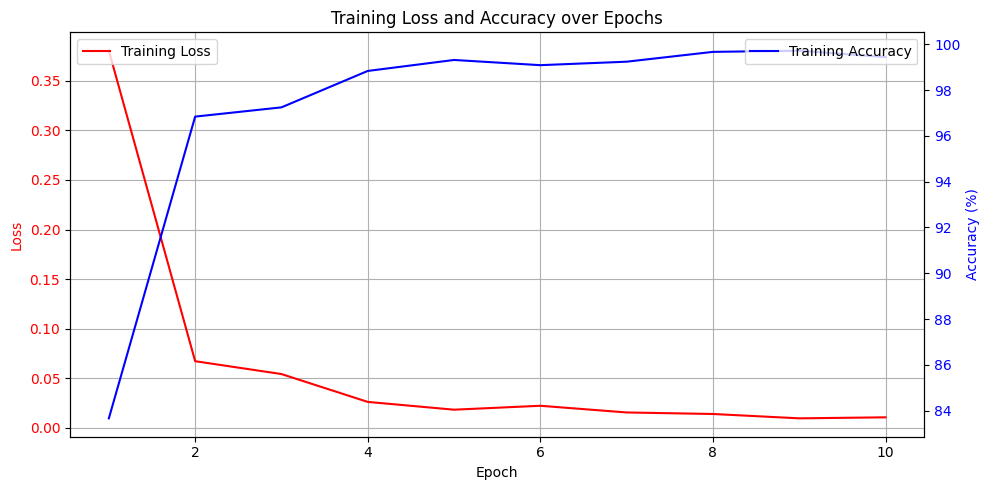


Đánh giá trên tập huấn luyện:
Classification Report:
              precision    recall  f1-score   support

   Different       1.00      1.00      1.00      1957
        Same       1.00      1.00      1.00      2003

    accuracy                           1.00      3960
   macro avg       1.00      1.00      1.00      3960
weighted avg       1.00      1.00      1.00      3960

F1 Score: 0.9990, Precision: 0.9990, Recall: 0.9990


In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import random
from torchvision import transforms

# Giả định rằng SiameseNetwork, SiameseFaceDataset, ContrastiveLoss, train_siamese_model, và evaluate_siamese_model đã được định nghĩa

if __name__ == "__main__":
    # Thiết lập device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Transform cho ảnh
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Tạo dataset và dataloader
    dataset = SiameseFaceDataset(root_dir=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Khởi tạo mô hình và các thành phần
    model = SiameseNetwork().to(device)
    criterion = ContrastiveLoss(margin=2.0)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Huấn luyện mô hình
    train_losses, train_accuracies = train_siamese_model(model, dataloader, criterion, optimizer, num_epochs=10, device=device)
    
    # Vẽ biểu đồ loss và accuracy trong cùng một khung hình
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Biểu đồ Loss trên trục y bên trái
    ax1.plot(range(1, len(train_losses)+1), train_losses, 'r-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    
    # Biểu đồ Accuracy trên trục y bên phải
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(train_accuracies)+1), train_accuracies, 'b-', label='Training Accuracy')
    ax2.set_ylabel('Accuracy (%)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='upper right')
    
    plt.title('Training Loss and Accuracy over Epochs')
    plt.tight_layout()
    plt.show()
    
    # Đánh giá mô hình
    print("\nĐánh giá trên tập huấn luyện:")
    f1, precision, recall = evaluate_siamese_model(model, dataloader, device)
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Chuẩn bị ảnh tham chiếu (reference images) cho dự đoán
    reference_images = []
    for label, img_paths in dataset.label_to_images.items():
        # Chọn một ảnh đại diện cho mỗi nhãn
        reference_images.append((random.choice(img_paths), label))

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Transform cho ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tạo dataset và dataloader
dataset = SiameseFaceDataset(root_dir=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Khởi tạo mô hình và các thành phần
model = SiameseNetwork().to(device)

model.load_state_dict(torch.load(r"C:\Users\Divu\Desktop\DADN\detect_face\siamese_face_recognition_model.pth"))
model.eval()
# Đánh giá mô hình
print("\nĐánh giá trên tập huấn luyện:")
f1, precision, recall = evaluate_siamese_model(model, dataloader, device)
print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Chuẩn bị ảnh tham chiếu (reference images) cho dự đoán
reference_images = []
for label, img_paths in dataset.label_to_images.items():
    reference_images.append((random.choice(img_paths), label))

# Dự đoán trên thư mục test
test_folder = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/thinh2"
predict_siamese_folder(model, test_folder, reference_images, transform, dataset.label_to_idx, device, threshold=1.0)

c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Đánh giá trên tập huấn luyện:
Classification Report:
              precision    recall  f1-score   support

   Different       1.00      1.00      1.00      1912
        Same       1.00      1.00      1.00      1986

    accuracy                           1.00      3898
   macro avg       1.00      1.00      1.00      3898
weighted avg       1.00      1.00      1.00      3898

F1 Score: 0.9997, Precision: 0.9997, Recall: 0.9997

Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/thinh2
Image: face_00000.png
Prediction: thinh2 (Distance: 0.0000)
Inference time: 0.034632 seconds
--------------------------------------------------
Image: face_00001.png
Prediction: thinh2 (Distance: 0.1476)
Inference time: 0.034661 seconds
--------------------------------------------------
Image: face_00002.png
Prediction: thinh2 (Distance: 0.5644)
Inference time: 0.038668 seconds
--------------------------------------------------
Image: face_00003.png
Prediction: thinh2 (D

In [8]:
test_folder = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/Luan"
predict_siamese_folder(model, test_folder, reference_images, transform, dataset.label_to_idx, device, threshold=1.0)


Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/Luan
Image: face_00001_0.png
Prediction: Luan (Distance: 0.4015)
Inference time: 0.367086 seconds
--------------------------------------------------
Image: face_00003_0.png
Prediction: Luan (Distance: 0.1525)
Inference time: 0.029791 seconds
--------------------------------------------------
Image: face_00004_0.png
Prediction: Luan (Distance: 0.1779)
Inference time: 0.029962 seconds
--------------------------------------------------
Image: face_00005_0.png
Prediction: Luan (Distance: 0.1891)
Inference time: 0.030282 seconds
--------------------------------------------------
Image: face_00006_0.png
Prediction: Luan (Distance: 0.3579)
Inference time: 0.029832 seconds
--------------------------------------------------
Image: face_00007_0.png
Prediction: Luan (Distance: 0.1229)
Inference time: 0.034109 seconds
--------------------------------------------------
Image: face_00008_0.png
Prediction: Luan (Dist

In [9]:
test_folder = r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/unknown"
predict_siamese_folder(model, test_folder, reference_images, transform, dataset.label_to_idx, device, threshold=1.0)


Predicting images in folder: C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces/unknown
Image: face_00001_0.png
Prediction: unknown (Distance: 0.0560)
Inference time: 0.256989 seconds
--------------------------------------------------
Image: face_00002_0.png
Prediction: unknown (Distance: 0.0814)
Inference time: 0.034086 seconds
--------------------------------------------------
Image: face_00005_0.png
Prediction: unknown (Distance: 0.0781)
Inference time: 0.024928 seconds
--------------------------------------------------
Image: face_00007_0.png
Prediction: unknown (Distance: 0.0816)
Inference time: 0.028777 seconds
--------------------------------------------------
Image: face_00008_0.png
Prediction: unknown (Distance: 0.0613)
Inference time: 0.024466 seconds
--------------------------------------------------
Image: face_00010_0.png
Prediction: unknown (Distance: 0.0743)
Inference time: 0.025836 seconds
--------------------------------------------------
Image: face_00011_0.png
P

In [2]:
import os
import cv2
import time
from datetime import datetime
import face_recognition
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import glob
import random


# Hàm dự đoán cho Siamese Network
def predict(model, image, reference_images, transform, label_to_idx, device='cuda', threshold=1.0):
    model.eval()
    start_time = time.time()
    idx_to_label = {v: k for k, v in label_to_idx.items()}
    min_distance = float('inf')
    predicted_label = "Unknown"
    
    with torch.no_grad():
        image_tensor = transform(image).unsqueeze(0).to(device)
        feature1 = model.forward_one(image_tensor)
        
        for ref_img_path, ref_label in reference_images:
            ref_img = Image.open(ref_img_path).convert('RGB')
            ref_tensor = transform(ref_img).unsqueeze(0).to(device)
            feature2 = model.forward_one(ref_tensor)
            distance = torch.nn.functional.pairwise_distance(feature1, feature2).item()
            
            if distance < min_distance and distance < threshold:
                min_distance = distance
                predicted_label = idx_to_label[ref_label]
    
    end_time = time.time()
    inference_time = end_time - start_time
    return predicted_label, inference_time

class FaceRecognitionSystem:
    def __init__(self, dataset_path=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", detection_method="hog", model_path="siamese_face_recognition_simple_cnn.pth"):
        self.dataset_path = dataset_path
        self.detection_method = detection_method
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Transform cho ảnh
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Tạo danh sách nhãn và ảnh tham chiếu
        self.label_to_idx = {}
        self.reference_images = []
        folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
        for idx, folder in enumerate(sorted(folders)):
            self.label_to_idx[folder] = idx
            # Chọn một ảnh tham chiếu ngẫu nhiên cho mỗi nhãn
            image_files = glob.glob(os.path.join(dataset_path, folder, "*.jpg")) + \
                         glob.glob(os.path.join(dataset_path, folder, "*.png"))
            if image_files:
                self.reference_images.append((random.choice(image_files), idx))
        
        self.num_classes = len(self.label_to_idx)
        
        # Khởi tạo mô hình Siamese Network
        self.model = SiameseNetwork().to(self.device)
        
        # Tải trạng thái mô hình
        try:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()
            print(f"✅ Mô hình Siamese Network đã được tải từ {model_path}")
        except Exception as e:
            print(f"❌ Lỗi khi tải mô hình: {e}")
            print("Vui lòng huấn luyện lại mô hình Siamese Network với dataset hiện tại.")

    def draw_rectangles(self, frame, top, right, bottom, left, label="Face"):
        padding = 0
        top = max(0, top - padding)
        left = max(0, left - padding)
        right = min(frame.shape[1], right + padding)
        bottom = min(frame.shape[0], bottom + padding)
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
        cv2.putText(frame, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return frame

    def capture_images(self, num_images=10, person_name=None):
        if person_name:
            output_dir = os.path.join(self.dataset_path, person_name)
        else:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            output_dir = os.path.join(self.dataset_path, f"person_{timestamp}")
        
        os.makedirs(output_dir, exist_ok=True)
        print(f"📁 Lưu ảnh khuôn mặt vào thư mục: {output_dir}")

        video = cv2.VideoCapture(0)
        if not video.isOpened():
            print("❌ Không thể mở webcam")
            return

        print(f"🚀 Bắt đầu chụp {num_images} ảnh khuôn mặt...")
        count = 0
        while count < num_images:
            ret, frame = video.read()
            if not ret:
                print("❌ Không thể lấy khung hình từ webcam")
                break

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_locations = face_recognition.face_locations(rgb_frame, model=self.detection_method)

            if face_locations:
                top, right, bottom, left = face_locations[0]
                padding = 0
                top_padded = max(0, top - padding)
                left_padded = max(0, left - padding)
                right_padded = min(frame.shape[1], right + padding)
                bottom_padded = min(frame.shape[0], bottom + padding)

                face_img = frame[top_padded:bottom_padded, left_padded:right_padded]
                face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_img_pil = Image.fromarray(face_img_rgb)

                result, _ = predict(self.model, face_img_pil, self.reference_images, self.transform, self.label_to_idx, self.device)
                frame = self.draw_rectangles(frame, top, right, bottom, left, label=result)

                filename = f"face_{count:05d}.png"
                filepath = os.path.join(output_dir, filename)
                cv2.imwrite(filepath, face_img)
                print(f"📸 Đã lưu khuôn mặt thứ {count + 1}/{num_images}: {filepath}")
                count += 1
            else:
                print(f"⚠️ Không phát hiện khuôn mặt trong khung hình thứ {count + 1}")
                cv2.imshow("Face Detection", frame)

            cv2.imshow("Face Detection", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                print("🛑 Người dùng đã thoát")
                break
            time.sleep(1)

        video.release()
        cv2.destroyAllWindows()
        print(f"✅ Hoàn tất! Đã lưu {count} ảnh khuôn mặt vào {output_dir}")

    def recognize_faces(self):
        video = cv2.VideoCapture(0)
        if not video.isOpened():
            print("❌ Không thể mở webcam")
            return

        print("🚀 Bắt đầu nhận diện khuôn mặt từ webcam...")
        while True:
            ret, frame = video.read()
            if not ret:
                print("❌ Không thể lấy khung hình từ webcam")
                break

            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            face_locations = face_recognition.face_locations(rgb_frame, model=self.detection_method)

            for top, right, bottom, left in face_locations:
                padding = 0
                top_padded = max(0, top - padding)
                left_padded = max(0, left - padding)
                right_padded = min(frame.shape[1], right + padding)
                bottom_padded = min(frame.shape[0], bottom + padding)

                face_img = frame[top_padded:bottom_padded, left_padded:right_padded]
                face_img_rgb = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_img_pil = Image.fromarray(face_img_rgb)

                result, _ = predict(self.model, face_img_pil, self.reference_images, self.transform, self.label_to_idx, self.device, threshold=0.5)
                frame = self.draw_rectangles(frame, top, right, bottom, left, label=result)

            cv2.imshow("Face Recognition", frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                print("🛑 Người dùng đã thoát")
                break

        video.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    frs = FaceRecognitionSystem(dataset_path=r"C:\Users\Divu\Desktop\DADN\detect_face\extracted_faces", model_path=r"C:\Users\Divu\Desktop\DADN\detect_face\siamese_face_recognition_model.pth")
    mode = input("Chọn chế độ (1: Chụp ảnh, 2: Nhận diện): ").strip()
    if mode == "1":
        person_name = input("Nhập tên người (hoặc để trống để dùng timestamp): ").strip()
        frs.capture_images(num_images=10, person_name=person_name if person_name else None)
    elif mode == "2":
        frs.recognize_faces()

c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Divu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Mô hình Siamese Network đã được tải từ C:\Users\Divu\Desktop\DADN\detect_face\siamese_face_recognition_model.pth
🚀 Bắt đầu nhận diện khuôn mặt từ webcam...
🛑 Người dùng đã thoát
